# ChebGCNs 


Spectral Graph ConvNets<br>
Convolutional Neural Networks on Graphs with Fast Localized Spectral Filtering<br>
M Defferrard, X Bresson, P Vandergheynst<br>

DOC : https://docs.dgl.ai/en/latest/api/python/nn.pytorch.html?highlight=cheb#dgl.nn.pytorch.conv.ChebConv

In [1]:
import os
import sys
import time
import numpy as np

# -------------Torch-------------------
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# -------------Graph-------------------
import dgl
import networkx as nx
import matplotlib.pyplot as plt

from utils import set_device
from laplacian import normalized_laplacian

# os.environ['KMP_DUPLICATE_LIB_OK']='True'

sys.path.insert(0, "lib/")
%load_ext autoreload
%autoreload 2

In [2]:
# GPU Compatibility
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

device = set_device(verbose=True)

cuda available


# MNIST

In [3]:
# Downloads the dataset if not found locally
from Dataset import check_mnist_dataset_exists, datasampler

_ = check_mnist_dataset_exists()

nb_selected_train_data = 640
nb_selected_test_data = 128

train_data, train_labels, test_data, test_labels = datasampler(
    nb_selected_train_data, nb_selected_test_data
)

In [4]:
# Import the dataset from file
from Dataset import MNISTDataset

In [5]:
trainset = MNISTDataset(train_data, train_labels)
testset = MNISTDataset(test_data, test_labels)

## Convolution layer and classifier


In [6]:
from model import Classifier

In [7]:
def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

# Debug section
Verifying all of the steps

In [10]:
# g, l = collate((trainset[0], trainset[1]))
g, l = trainset[0]

# model_parameters
in_features = 1
first_conv_out = 32
second_conv_out = 50
hidden_layer_classifier = 512
k = 5
n_classes = trainset.num_classes

net = Classifier(
    in_features, first_conv_out, second_conv_out, hidden_layer_classifier, n_classes, k
).to(device)
print("-------------------- Network model --------------------\n", net)

t = time.time()
# Calculate L
g.to(device)
L = normalized_laplacian(g)
print("L", L, "size:", len(L), "time", time.time() - t)


print("\n --------------------  Output for graph g:  --------------------\n", net(g, L))

-------------------- Network model --------------------
 Classifier(
  (layers): ModuleList(
    (0): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=5, out_features=32, bias=True)
      )
    )
    (1): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=160, out_features=50, bias=True)
      )
    )
  )
  (classify): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)
L tensor(indices=tensor([[  0,   0,   0,  ..., 783, 783, 783],
                       [  0,   1,  28,  ..., 755, 782, 783]]),
       values=tensor([-2.2204e-15, -4.0825e-01, -4.0825e-01,  ...,
                      -4.0825e-01, -4.0825e-01, -2.2204e-15]),
       size=(784, 784), nnz=3808, layout=torch.sparse_coo) size: 784 time 0.02954268455505371

 --------------------  Output for graph g:  --------------------
 tensor([[ 0.0820,  0.0499

In [11]:
g

DGLGraph(num_nodes=784, num_edges=3024,
         ndata_schemes={}
         edata_schemes={})

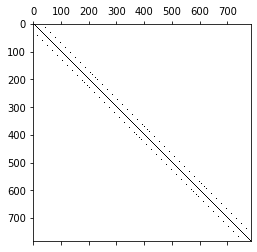

In [12]:
plt.spy(L.to_dense())

# Model definition for training

In [13]:
# del net
# model_parameters
in_features = 1
first_conv_out = 32
second_conv_out = 50
hidden_layer_classifier = 512
k = 25
n_classes = trainset.num_classes

net = Classifier(
    in_features, first_conv_out, second_conv_out, hidden_layer_classifier, n_classes, k
)
print(net)
if torch.cuda.is_available():
    net.to(device)

# net.parameters()

Classifier(
  (layers): ModuleList(
    (0): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=25, out_features=32, bias=True)
      )
    )
    (1): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=800, out_features=50, bias=True)
      )
    )
  )
  (classify): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)


# Training pipe

In [14]:
# Use PyTorch's DataLoader and the collate function
# defined before.
data_loader = DataLoader(trainset, batch_size=512,
                         shuffle=True, collate_fn=collate)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.005)

## Training time

In [15]:
from laplacian import normalized_laplacian

epoch_losses = []
net.train()
# torch.autograd.set_detect_anomaly(True)

for epoch in range(20):
    epoch_loss = 0
    t0 = time.time()
    for iter, (bg, label) in enumerate(data_loader):
        if iter == 0:
            L = normalized_laplacian(bg).to(device)
            t = time.time()

        if torch.cuda.is_available():
            bg.to(device)

        prediction = net(bg, L)
        if iter == 0:
            print("prediction time:", time.time() - t)
            t = time.time()
        # print("Prediction:", prediction,'len:',prediction.size())  #DEBUG
        loss = loss_func(prediction, label.to(device))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if iter == 0:
            print("optimizer time:", time.time() - t)
            t = time.time()

        epoch_loss += loss.detach().item()

    epoch_loss /= iter + 1
    print(
        "Epoch {}, loss {:.4f}, in {:.2f}(s) ".format(
            epoch, epoch_loss, time.time() - t0
        )
    )
    epoch_losses.append(epoch_loss)

prediction time: 0.0012531280517578125
optimizer time: 0.0063266754150390625
Epoch 0, loss 2.3050, in 7.99(s) 


KeyboardInterrupt: 

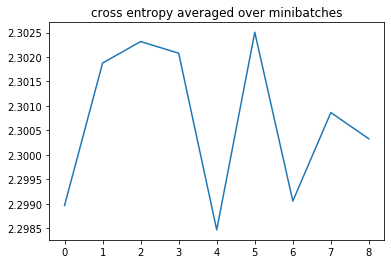

In [22]:
plt.title("cross entropy averaged over minibatches")
plt.plot(epoch_losses[1:])
plt.show()

In [23]:
torch.cuda.empty_cache()

## Test Metrics

In [16]:
# BATCHED DGL EXAMPLE
import sklearn
from sklearn.metrics import classification_report

# Change

net.eval()
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))
test_bg = dgl.batch(test_X).to(device)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
L, lmax = laplacian(test_bg)
L = rescale_L(L).to(device)
probs_Y = torch.softmax(net(test_bg, L), 1).to(torch.device("cpu"))
sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)

# sklearn.metrics.classification_report(test_Y,argmax_Y)

print(
    "Accuracy of sampled predictions on the test set: {:.4f}%".format(
        (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100
    )
)
print(
    "Accuracy of argmax predictions on the test set: {:4f}%".format(
        (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100
    )
)

/home/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


RuntimeError: size mismatch, m1: [64 x 78400], m2: [39200 x 512] at /opt/conda/conda-bld/pytorch_1579040055865/work/aten/src/THC/generic/THCTensorMathBlas.cu:290

## Saving

In [16]:
from utils import save_model

save_model("Model1", net)

# Others

$h_i^{l+1}$ = $\sum_{k=0}^{K-1} W^{k, l}z_i^{k, l}$

$Z^{0, l}$ = $H^{l}$

$Z^{1, l}$ =$ \hat{L} \cdot H^{l}$

$Z^{k, l}$ = $2 \cdot \hat{L} \cdot Z^{k-1, l} - Z^{k-2, l}$

$\hat{L}$ = $2\left(I - \hat{D}^{-1/2} \hat{A} \hat{D}^{-1/2}\right)/\lambda_{max} - I$